In [1]:
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
random_state = 42

scaler = StandardScaler()
# 加载数据集
data_ssgsea = pd.read_csv('ssgsea_10.csv')
X_ssgsea = data_ssgsea.iloc[:, 1:]
y_ssgsea = data_ssgsea.iloc[:, 0]  # 假设标签在 data1 的第一列

X_ssgsea_scaled = scaler.fit_transform(X_ssgsea)

# 拆分数据集
X_train_ssgsea, X_test_ssgsea, y_train_ssgsea, y_test_ssgsea = train_test_split(X_ssgsea_scaled, y_ssgsea, test_size=0.2, random_state = random_state)

data_ppi = pd.read_csv('ppi_10.csv')
X_ppi = data_ppi.iloc[:, 1:]
y_ppi = data_ppi.iloc[:, 0]  # 假设标签在 data1 的第一列

X_ppi_scaled = scaler.fit_transform(X_ppi)

# 拆分数据集
X_train_ppi, X_test_ppi, y_train_ppi, y_test_ppi = train_test_split(X_ppi_scaled, y_ppi, test_size=0.2, random_state = random_state)

data_wgcna = pd.read_csv('wgcna_10.csv')
X_wgcna = data_wgcna.iloc[:, 1:]
y_wgcna = data_wgcna.iloc[:, 0]  # 假设标签在 data1 的第一列

X_wgcna_scaled = scaler.fit_transform(X_wgcna)

# 拆分数据集
X_train_wgcna, X_test_wgcna, y_train_wgcna, y_test_wgcna = train_test_split(X_wgcna_scaled, y_wgcna, test_size=0.2, random_state = random_state)

In [2]:
import joblib
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 载入的基础模型
ssgsea = joblib.load('./basemodel/lda_ssgsea.joblib')
ppi = joblib.load('./basemodel/lda_ppi.joblib')
wgcna = joblib.load('./basemodel/rf_wgcna.joblib')

ssgsea.fit(X_train_ssgsea, y_train_ssgsea.squeeze())
ppi.fit(X_train_ppi, y_train_ppi.squeeze())
wgcna.fit(X_train_wgcna, y_train_wgcna.squeeze())

# 获取每个模型的预测概率
pred_ssgsea_train = ssgsea.predict_proba(X_train_ssgsea)[:, 1]
pred_ppi_train = ppi.predict_proba(X_train_ppi)[:, 1]
pred_wgcna_train = wgcna.predict_proba(X_train_wgcna)[:, 1]

pred_ssgsea_test = ssgsea.predict_proba(X_test_ssgsea)[:, 1]
pred_ppi_test = ppi.predict_proba(X_test_ppi)[:, 1]
pred_wgcna_test = wgcna.predict_proba(X_test_wgcna)[:, 1]



In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 合并这几个预测概率作为新的特征矩阵
X_train = np.column_stack((pred_ssgsea_train, pred_ppi_train, pred_wgcna_train))
y_train = y_train_ssgsea.squeeze()

X_test = np.column_stack((pred_ssgsea_test, pred_ppi_test, pred_wgcna_test))
y_test = y_test_ssgsea.squeeze()


In [4]:
# 初始化逻辑回归模型
lr_model = LogisticRegression()

# 训练逻辑回归模型
lr_model.fit(X_train, y_train)

# 保存模型
joblib.dump(lr_model, 'meta_model.joblib')

# 用训练好的模型进行预测
y_pred_meta = lr_model.predict_proba(X_test)[:, 1]

# 计算AUC评分
auc_score = roc_auc_score(y_test, y_pred_meta)

print(f"逻辑回归模型的AUC评分：{auc_score}")

逻辑回归模型的AUC评分：0.9130434782608695


In [5]:
# 输出逻辑回归模型的系数和截距
print("逻辑回归模型的系数：", lr_model.coef_)
print("逻辑回归模型的截距：", lr_model.intercept_)

# 每个特征对应的系数
feature_names = ['ssgsea', 'ppi', 'wgcna']
for feature, coef in zip(feature_names, lr_model.coef_[0]):
    print(f"{feature} 的系数是: {coef}")

# 完整的决策函数
decision_function_values = lr_model.decision_function(X_test)
print("逻辑回归模型的决策函数值：", decision_function_values)

import numpy as np

# 计算每个特征的 OR
odds_ratios = np.exp(lr_model.coef_[0])

# 输出每个特征的 OR
for feature, odds_ratio in zip(feature_names, odds_ratios):
    print(f"{feature} 的OR是: {odds_ratio}")

逻辑回归模型的系数： [[1.38489472 1.84189248 4.35070584]]
逻辑回归模型的截距： [-3.60919987]
ssgsea 的系数是: 1.3848947203583262
ppi 的系数是: 1.8418924826643928
wgcna 的系数是: 4.350705839463076
逻辑回归模型的决策函数值： [-0.18468456  1.37301036 -2.54972807 -1.99780769 -0.15712826 -1.10314029
 -0.50452174  0.65185218 -0.35660584 -0.2818821  -1.03882943 -0.44261996
 -0.9313434  -2.69878108 -1.81533001 -0.69397205 -0.25579797 -1.47539245
 -1.61913099  1.13430608  0.39225602 -0.88432738  0.37391324 -0.87488784
 -1.18131243 -1.31449111 -0.33775106  0.83168679  0.40785661 -0.10388506
 -0.85204044  0.32576191 -0.27042652 -0.24001301 -1.48497882]
ssgsea 的OR是: 3.994405353114979
ppi 的OR是: 6.308465633144003
wgcna 的OR是: 77.53316958672102


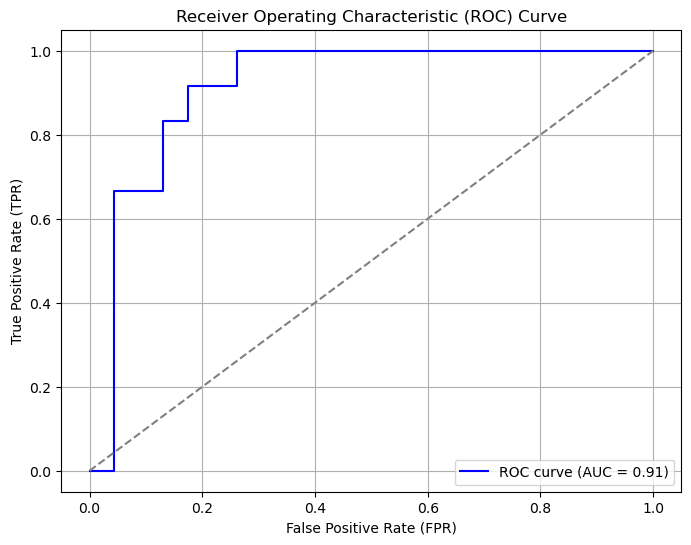

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 计算 ROC 曲线的假阳性率（FPR）、真阳性率（TPR）和阈值
fpr, tpr, thresholds = roc_curve(y_test, y_pred_meta)

# 计算 AUC（曲线下面积）
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 随机猜测的对角线
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


 model AUC: 0.9130


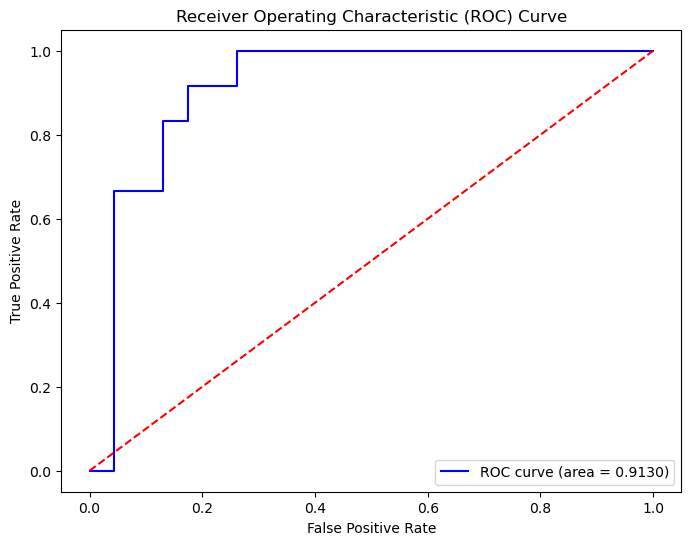

Accuracy: 0.8285714285714286
Precision: 0.875
AUC: 0.9130434782608695
召回率: 0.5833333333333334
F1得分: 0.7
Confusion Matrix: 
 [[22  1]
 [ 5  7]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.96      0.88        23
           1       0.88      0.58      0.70        12

    accuracy                           0.83        35
   macro avg       0.84      0.77      0.79        35
weighted avg       0.84      0.83      0.82        35



In [7]:
import joblib

### 导入一些库
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as GBDT
from sklearn.ensemble import ExtraTreesClassifier as ET
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as ADA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (GradientBoostingClassifier, BaggingClassifier, 
                              AdaBoostClassifier, RandomForestClassifier, 
                              ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (QuadraticDiscriminantAnalysis, 
                                           LinearDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (GradientBoostingClassifier, BaggingClassifier, 
                              AdaBoostClassifier, RandomForestClassifier, 
                              ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (QuadraticDiscriminantAnalysis, 
                                           LinearDiscriminantAnalysis)
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
# 绘制特征重要性图
import matplotlib.pyplot as plt
#建模调参
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve
import numpy as np
np.random.seed(42)

X_val_meta = X_test
y_val_meta = y_test

pred_proba = lr_model.predict_proba(X_val_meta)[:, 1]
y_pred = lr_model.predict(X_val_meta)

# 计算准确率
accuracy = accuracy_score(y_val_meta, y_pred)
# 计算精确率
precision = precision_score(y_val_meta, y_pred)
# 计算AUC
auc = roc_auc_score(y_val_meta, pred_proba)
# 计算召回率
recall = recall_score(y_val_meta, y_pred)
# 计算F1得分
f1 = f1_score(y_val_meta, y_pred)
# 8. 计算 AUC 值
auc_value = roc_auc_score(y_val_meta, pred_proba)
print(f' model AUC: {auc_value:.4f}')

# 9. 计算 FPR 和 TPR
fpr, tpr, thresholds = roc_curve(y_val_meta, pred_proba)
# 10. 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # 对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("AUC:", auc)
print("召回率:" ,recall)
print("F1得分:" ,f1)

print("Confusion Matrix: \n", metrics.confusion_matrix(y_val_meta, y_pred))  # 计算混淆矩阵
print("Classification Report: \n", metrics.classification_report(y_val_meta, y_pred))  # 计算分类报告




In [8]:
#### 仅使用训练集计算约登指数

y_pred_proba_train = lr_model.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, thresholds = roc_curve(y_train, y_pred_proba_train)
youden_index = tpr_train - fpr_train
best_threshold = thresholds[np.argmax(youden_index)]
print(best_threshold) 

0.4236985186255568


 model AUC: 0.9130


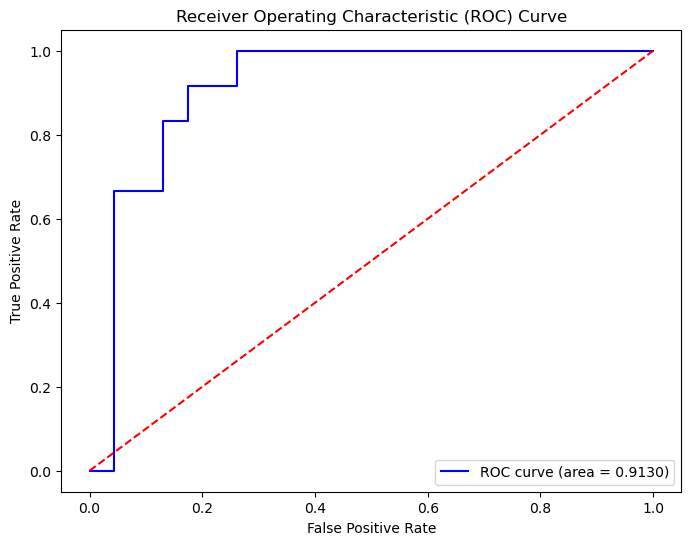

Accuracy: 0.8571428571428571
Precision: 0.7333333333333333
AUC: 0.9130434782608695
召回率: 0.9166666666666666
F1得分: 0.8148148148148148
Confusion Matrix: 
 [[19  4]
 [ 1 11]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.83      0.88        23
           1       0.73      0.92      0.81        12

    accuracy                           0.86        35
   macro avg       0.84      0.87      0.85        35
weighted avg       0.88      0.86      0.86        35



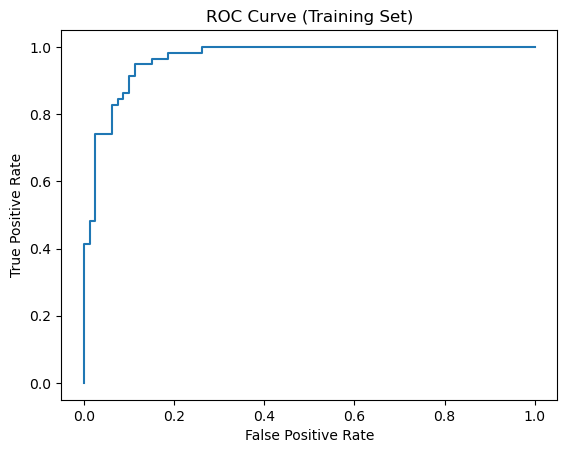

训练集准确率: 0.9130434782608695
训练集精确率: 0.859375
训练集AUC: 0.9650862068965518
训练集召回率: 0.9482758620689655
训练集F1得分: 0.9016393442622951


In [9]:
pred_proba = lr_model.predict_proba(X_test)[:, 1]
y_pred = (pred_proba >= best_threshold).astype(int) 

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
# 计算精确率
precision = precision_score(y_test, y_pred)
# 计算AUC
auc = roc_auc_score(y_test, pred_proba)
# 计算召回率
recall = recall_score(y_test, y_pred)
# 计算F1得分
f1 = f1_score(y_test, y_pred)
# 8. 计算 AUC 值
auc_value = roc_auc_score(y_test, pred_proba)
print(f' model AUC: {auc_value:.4f}')

# 9. 计算 FPR 和 TPR
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
# 10. 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # 对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("AUC:", auc)
print("召回率:" ,recall)
print("F1得分:" ,f1)

print("Confusion Matrix: \n", metrics.confusion_matrix(y_test, y_pred))  # 计算混淆矩阵
print("Classification Report: \n", metrics.classification_report(y_test, y_pred))  # 计算分类报告

# 在训练集上进行预测

y_pred_proba_train = lr_model.predict_proba(X_train)[:, 1]
y_pred_train = (y_pred_proba_train >= best_threshold).astype(int)

# 计算训练集上的各项指标
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
auc_train = roc_auc_score(y_train, y_pred_proba_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

# 绘制训练集的ROC曲线
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_proba_train)
plt.plot(fpr_train, tpr_train)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Training Set)')
plt.show()

# 输出训练集上的各项指标
print("训练集准确率:", accuracy_train)
print("训练集精确率:", precision_train)
print("训练集AUC:", auc_train)
print("训练集召回率:", recall_train)
print("训练集F1得分:", f1_train)

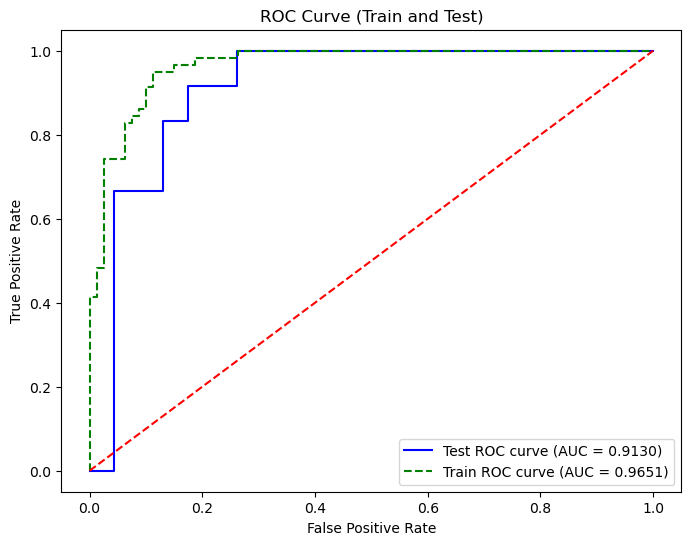

In [10]:
# 绘制训练集和测试集的ROC曲线
plt.figure(figsize=(8, 6))

# 绘制测试集 ROC 曲线
fpr, tpr, _ = roc_curve(y_test, pred_proba)
plt.plot(fpr, tpr, color='blue', label=f'Test ROC curve (AUC = {auc_value:.4f})')

# 绘制训练集 ROC 曲线，设置为虚线
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
plt.plot(fpr_train, tpr_train, color='green', linestyle='--', label=f'Train ROC curve (AUC = {auc_train:.4f})')

# 对角线
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Train and Test)')
plt.legend(loc='lower right')
plt.show()


In [11]:
ssgsea = joblib.load('./basemodel/lda_ssgsea.joblib')
ppi = joblib.load('./basemodel/lda_ppi.joblib')
wgcna = joblib.load('./basemodel/rf_wgcna.joblib')
meta_model = joblib.load('./meta_model.joblib')

In [12]:
print(ssgsea)
print(ppi)
print(wgcna)
print(meta_model)

LinearDiscriminantAnalysis()
LinearDiscriminantAnalysis()
RandomForestClassifier(max_depth=16, min_samples_split=19, n_estimators=240,
                       random_state=42)
LogisticRegression()


In [13]:
# 基础模型测试集评价结果

import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
random_state = 42

scaler = StandardScaler()
# 加载数据集
data_ssgsea = pd.read_csv('ssgsea_10.csv')
X_ssgsea = data_ssgsea.iloc[:, 1:]
y_ssgsea = data_ssgsea.iloc[:, 0]  # 假设标签在 data1 的第一列

X_ssgsea_scaled = scaler.fit_transform(X_ssgsea)

# 拆分数据集
X_train_ssgsea, X_test_ssgsea, y_train_ssgsea, y_test_ssgsea = train_test_split(X_ssgsea_scaled, y_ssgsea, test_size=0.2, random_state = random_state)

data_ppi = pd.read_csv('ppi_10.csv')
X_ppi = data_ppi.iloc[:, 1:]
y_ppi = data_ppi.iloc[:, 0]  # 假设标签在 data1 的第一列

X_ppi_scaled = scaler.fit_transform(X_ppi)

# 拆分数据集
X_train_ppi, X_test_ppi, y_train_ppi, y_test_ppi = train_test_split(X_ppi_scaled, y_ppi, test_size=0.2, random_state = random_state)

data_wgcna = pd.read_csv('wgcna_10.csv')
X_wgcna = data_wgcna.iloc[:, 1:]
y_wgcna = data_wgcna.iloc[:, 0]  # 假设标签在 data1 的第一列

X_wgcna_scaled = scaler.fit_transform(X_wgcna)

# 拆分数据集
X_train_wgcna, X_test_wgcna, y_train_wgcna, y_test_wgcna = train_test_split(X_wgcna_scaled, y_wgcna, test_size=0.2, random_state = random_state)

ssgsea.fit(X_train_ssgsea, y_train_ssgsea.squeeze())
ppi.fit(X_train_ppi, y_train_ppi.squeeze())
wgcna.fit(X_train_wgcna, y_train_wgcna.squeeze())

 #预测概率和标签
y_pred_ssgsea = ssgsea.predict(X_test_ssgsea)
y_prob_ssgsea = ssgsea.predict_proba(X_test_ssgsea)[:, 1]

y_pred_ppi = ppi.predict(X_test_ppi)
y_prob_ppi = ppi.predict_proba(X_test_ppi)[:, 1]

y_pred_wgcna = wgcna.predict(X_test_wgcna)
y_prob_wgcna = wgcna.predict_proba(X_test_wgcna)[:, 1]





# 计算指标
def evaluate_model(y_test, y_pred, y_prob, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("-" * 30)

# 评估各个模型
evaluate_model(y_test_ssgsea, y_pred_ssgsea, y_prob_ssgsea, "ssGSEA Model")
evaluate_model(y_test_ppi, y_pred_ppi, y_prob_ppi, "PPI Model")
evaluate_model(y_test_wgcna, y_pred_wgcna, y_prob_wgcna, "WGCNA Model")


ssGSEA Model Performance:
Accuracy: 0.6571
Precision: 0.5000
Recall: 0.4167
F1 Score: 0.4545
AUC: 0.7645
------------------------------
PPI Model Performance:
Accuracy: 0.7143
Precision: 0.6667
Recall: 0.3333
F1 Score: 0.4444
AUC: 0.7319
------------------------------
WGCNA Model Performance:
Accuracy: 0.7714
Precision: 0.6667
Recall: 0.6667
F1 Score: 0.6667
AUC: 0.8587
------------------------------


In [14]:
# 基础模型训练集评价结果

#预测概率和标签
y_pred_ssgsea = ssgsea.predict(X_train_ssgsea)
y_prob_ssgsea = ssgsea.predict_proba(X_train_ssgsea)[:, 1]

y_pred_ppi = ppi.predict(X_train_ppi)
y_prob_ppi = ppi.predict_proba(X_train_ppi)[:, 1]

y_pred_wgcna = wgcna.predict(X_train_wgcna)
y_prob_wgcna = wgcna.predict_proba(X_train_wgcna)[:, 1]





# 计算指标
def evaluate_model(y_test, y_pred, y_prob, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("-" * 30)

# 评估各个模型
evaluate_model(y_train_ssgsea, y_pred_ssgsea, y_prob_ssgsea, "ssGSEA Model")
evaluate_model(y_train_ppi, y_pred_ppi, y_prob_ppi, "PPI Model")
evaluate_model(y_train_wgcna, y_pred_wgcna, y_prob_wgcna, "WGCNA Model")

ssGSEA Model Performance:
Accuracy: 0.6957
Precision: 0.6667
Recall: 0.5517
F1 Score: 0.6038
AUC: 0.7584
------------------------------
PPI Model Performance:
Accuracy: 0.7029
Precision: 0.6889
Recall: 0.5345
F1 Score: 0.6019
AUC: 0.7636
------------------------------
WGCNA Model Performance:
Accuracy: 0.8913
Precision: 0.8909
Recall: 0.8448
F1 Score: 0.8673
AUC: 0.9625
------------------------------
